# Prédiction de maintenance des moteurs d'avion (NASA C-MAPSS)

Ce notebook présente un projet de **maintenance prédictive** sur des moteurs d’avion
(jeu de données simulé NASA **C-MAPSS**).

### Contexte métier

L’idée est de répondre à une question très simple côté exploitation :

> *« Est-ce qu’on peut repérer à l’avance les moteurs à risque pour planifier la maintenance
avant la casse ? »*

On dispose pour cela de :

- séries temporelles de **capteurs** (températures, pressions, vitesses, etc.) pour chaque moteur ;
- un historique de cycles jusqu’à la **panne** ;
- un jeu de test où l’on doit décider si le moteur est **“à risque”** ou non.

### Objectif ML 

1. Construire une cible de type **RUL** (*Remaining Useful Life*) à partir des séries temporelles.
2. En déduire une cible **binaire** `label_maintenance` indiquant si le moteur doit être mis en maintenance dans une certaine fenêtre métier.
3. Entraîner plusieurs modèles de classification (baselines + modèles non linéaires).
4. Choisir un **modèle final** et l’évaluer honnêtement sur un jeu de **test séparé**.
5. Ouvrir la “boîte noire” avec de l’**interprétabilité** (importances, SHAP).

### Pourquoi reformuler en classification binaire ?

Le jeu de données C-MAPSS est pensé à l’origine pour de la **régression de RUL**
(*Remaining Useful Life* : combien de cycles restent avant la panne).

Dans un contexte opérationnel, la question métier est légèrement différente :

> « Est-ce qu’on doit planifier une maintenance dans un certain délai raisonnable ? »

Pour se rapprocher de cette logique, je garde la RUL comme variable physique,
puis je la transforme en une **décision binaire** via une fenêtre d’alerte
`MAINTENANCE_WINDOW` (par exemple 30 cycles), qui joue le rôle d’un **paramètre métier**
plutôt que d’une quantité apprise automatiquement par le modèle.



In [20]:
#  Imports & configuration globale

from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display  # pour display(...)

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
)

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier

import shap  




# Dossier des données
datadir = Path("Docs")
PM_TRAIN_PATH = datadir / "PM_train.csv"
PM_TEST_PATH = datadir / "PM_test.csv"
PM_TRUTH_PATH = datadir / "PM_truth.csv"

# Seed pour la reproductibilité
RANDOM_STATE = 42

# Réglages d’affichage
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 130)

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

print(" Imports et configuration initiale chargés.")


 Imports et configuration initiale chargés.


In [21]:
# 2. Chargement des données & aperçu

print("Chargement des fichiers CSV...")

pm_train = pd.read_csv(PM_TRAIN_PATH)
pm_test = pd.read_csv(PM_TEST_PATH)
pm_truth = pd.read_csv(PM_TRUTH_PATH)

print(" Données chargées.")
print(f"pm_train : {pm_train.shape[0]} lignes, {pm_train.shape[1]} colonnes")
print(f"pm_test  : {pm_test.shape[0]} lignes, {pm_test.shape[1]} colonnes")
print(f"pm_truth : {pm_truth.shape[0]} lignes, {pm_truth.shape[1]} colonnes")

print("\n Aperçu de pm_train :")
display(pm_train.head())

print("\n Informations sur pm_train :")
pm_train.info()

print("\n Aperçu de pm_test :")
display(pm_test.head())

print("\n Aperçu de pm_truth :")
display(pm_truth.head())
print("pm_truth.columns :", pm_truth.columns.tolist())
print("pm_test.columns  :", pm_test.columns.tolist())

print("\npm_truth.head() :")
print(pm_truth.head().to_string(index=False))


Chargement des fichiers CSV...
 Données chargées.
pm_train : 20631 lignes, 26 colonnes
pm_test  : 13096 lignes, 26 colonnes
pm_truth : 100 lignes, 2 colonnes

 Aperçu de pm_train :


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044



 Informations sur pm_train :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        20631 non-null  int64  
 1   cycle     20631 non-null  int64  
 2   setting1  20631 non-null  float64
 3   setting2  20631 non-null  float64
 4   setting3  20631 non-null  float64
 5   s1        20631 non-null  float64
 6   s2        20631 non-null  float64
 7   s3        20631 non-null  float64
 8   s4        20631 non-null  float64
 9   s5        20631 non-null  float64
 10  s6        20631 non-null  float64
 11  s7        20631 non-null  float64
 12  s8        20631 non-null  float64
 13  s9        20631 non-null  float64
 14  s10       20631 non-null  float64
 15  s11       20631 non-null  float64
 16  s12       20631 non-null  float64
 17  s13       20631 non-null  float64
 18  s14       20631 non-null  float64
 19  s15       20631 non-null  float64
 20

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130



 Aperçu de pm_truth :


,id,cycle
0,1,112
1,2,98
2,3,69
3,4,82
4,5,91


pm_truth.columns : ['id', 'cycle']
pm_test.columns  : ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']

pm_truth.head() :
 id  cycle
  1    112
  2     98
  3     69
  4     82
  5     91


## 3. Exploration des données (EDA)

Dans cette section, on réalise une première exploration des données :

- Statistiques descriptives sur les variables numériques,
- Analyse des valeurs manquantes,
- Identification des variables candidates (capteurs, identifiants, etc.),
- Visualisation rapide de quelques distributions et corrélations.

L'objectif est de mieux comprendre la structure des données avant de définir précisément la cible et de construire les modèles.


Structure générale
Nombre de lignes pm_train : 20631
Nombre de colonnes pm_train : 26

Nombre de moteurs dans pm_train : 100
Nombre de moteurs dans pm_test  : 100

Résumé des cycles par moteur (train) :


,min,max,count
count,100.0,100.000000,100.000000
mean,1.0,206.310000,206.310000
std,0.0,46.342749,46.342749
min,1.0,128.000000,128.000000
25%,1.0,177.000000,177.000000
50%,1.0,199.000000,199.000000
75%,1.0,229.250000,229.250000
max,1.0,362.000000,362.000000



Résumé des cycles par moteur (test) :


,min,max,count
count,100.0,100.000000,100.000000
mean,1.0,130.960000,130.960000
std,0.0,53.593479,53.593479
min,1.0,31.000000,31.000000
25%,1.0,88.750000,88.750000
50%,1.0,133.500000,133.500000
75%,1.0,164.250000,164.250000
max,1.0,303.000000,303.000000



Types de colonnes 
Colonnes de pm_train :
['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']

Colonnes numériques (train) :
['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']

Colonnes 'setting' (hypothèse) : ['setting1', 'setting2', 'setting3']
Exemple de colonnes capteurs : ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8'] ...
Nombre total de capteurs (approx.) : 21

Valeurs manquantes (pm_train)
Aucune valeur manquante dans pm_train.

Statistiques descriptives des capteurs (train)


,count,mean,std,min,25%,50%,75%,max
s1,20631.0,518.670000,0.000000e+00,518.67,518.670,518.67,518.670,518.67
s2,20631.0,642.680934,5.000533e-01,641.21,642.325,642.64,643.000,644.53
s3,20631.0,1590.523119,6.131150e+00,1571.04,1586.260,1590.10,1594.380,1616.91
s4,20631.0,1408.933782,9.000605e+00,1382.25,1402.360,1408.04,1414.555,1441.49
s5,20631.0,14.620000,5.329200e-15,14.62,14.620,14.62,14.620,14.62
s6,20631.0,21.609803,1.388985e-03,21.60,21.610,21.61,21.610,21.61
s7,20631.0,553.367711,8.850923e-01,549.85,552.810,553.44,554.010,556.06
s8,20631.0,2388.096652,7.098548e-02,2387.90,2388.050,2388.09,2388.140,2388.56
s9,20631.0,9065.242941,2.208288e+01,9021.73,9053.100,9060.66,9069.420,9244.59
s10,20631.0,1.300000,0.000000e+00,1.30,1.300,1.30,1.300,1.30


Corrélations entre quelques capteurs


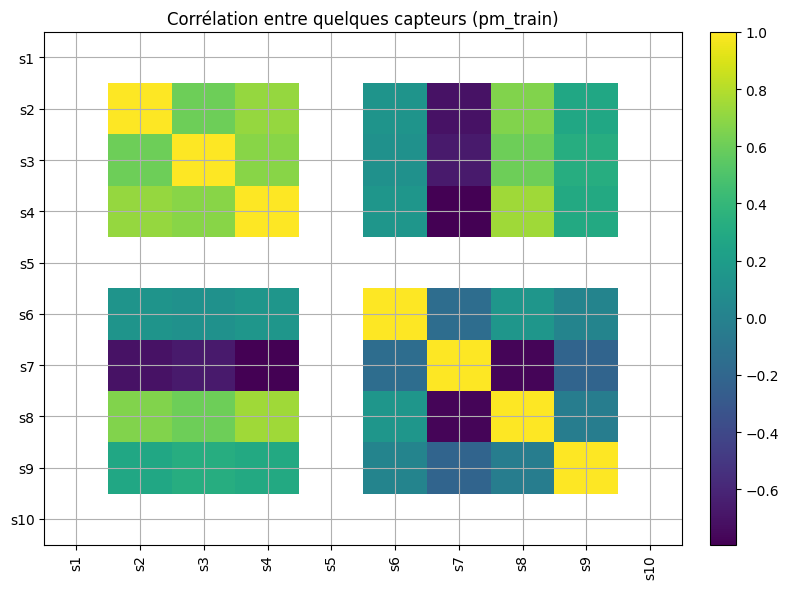


Distribution du nombre de cycles par moteur (train)


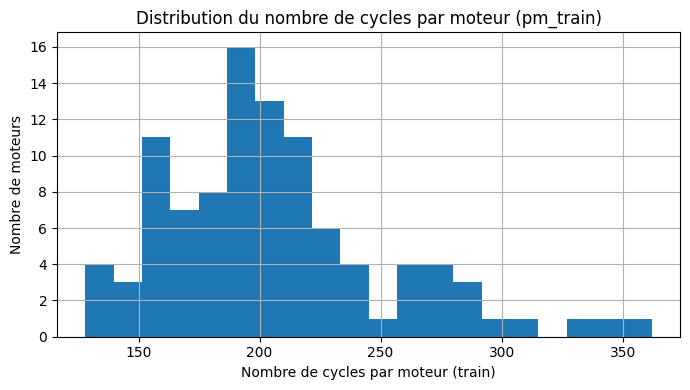

In [22]:
# 3. Exploration des données (EDA)

print("Structure générale")
print(f"Nombre de lignes pm_train : {pm_train.shape[0]}")
print(f"Nombre de colonnes pm_train : {pm_train.shape[1]}")

print(f"\nNombre de moteurs dans pm_train : {pm_train['id'].nunique()}")
print(f"Nombre de moteurs dans pm_test  : {pm_test['id'].nunique()}")

# Nombre de cycles par moteur (train / test)
cycles_train = pm_train.groupby("id")["cycle"].agg(["min", "max", "count"])
cycles_test = pm_test.groupby("id")["cycle"].agg(["min", "max", "count"])

print("\nRésumé des cycles par moteur (train) :")
display(cycles_train.describe())

print("\nRésumé des cycles par moteur (test) :")
display(cycles_test.describe())


print("\nTypes de colonnes ")
print("Colonnes de pm_train :")
print(pm_train.columns.tolist())

# Colonnes numériques
numeric_cols_train = pm_train.select_dtypes(include=[np.number]).columns.tolist()
print("\nColonnes numériques (train) :")
print(numeric_cols_train)

# On essaie de distinguer id / cycle / settings / capteurs
id_col = "id"
cycle_col = "cycle"

setting_cols = [c for c in numeric_cols_train if c.startswith("setting")]
sensor_cols = [
    c for c in numeric_cols_train
    if c not in [id_col, cycle_col] + setting_cols
]

print(f"\nColonnes 'setting' (hypothèse) : {setting_cols}")
print(f"Exemple de colonnes capteurs : {sensor_cols[:8]} ...")
print(f"Nombre total de capteurs (approx.) : {len(sensor_cols)}")


print("\nValeurs manquantes (pm_train)")
na_counts = pm_train.isna().sum()
na_counts = na_counts[na_counts > 0].sort_values(ascending=False)

if na_counts.empty:
    print("Aucune valeur manquante dans pm_train.")
else:
    display(na_counts.to_frame("nb_na").head(20))


print("\nStatistiques descriptives des capteurs (train)")
if sensor_cols:
    desc_sensors = pm_train[sensor_cols].describe().T
    display(desc_sensors.head(10))
else:
    print("Pas de colonnes capteurs détectées (vérifier la logique plus haut).")


print("Corrélations entre quelques capteurs")

subset = sensor_cols[:10]  # on ne prend qu'un sous-ensemble pour la lisibilité
corr = pm_train[subset].corr()

plt.figure(figsize=(8, 6))
im = plt.imshow(corr, aspect="auto")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(subset)), subset, rotation=90)
plt.yticks(range(len(subset)), subset)
plt.title("Corrélation entre quelques capteurs (pm_train)")
plt.tight_layout()
plt.show()

   

print("\nDistribution du nombre de cycles par moteur (train)")
plt.figure(figsize=(7, 4))
cycles_train["count"].hist(bins=20)
plt.xlabel("Nombre de cycles par moteur (train)")
plt.ylabel("Nombre de moteurs")
plt.title("Distribution du nombre de cycles par moteur (pm_train)")
plt.tight_layout()
plt.show()



## 4. Construction de la cible (RUL) et préparation des données

Cette section prépare les informations essentielles pour l’apprentissage.

### 4.1 RUL : Remaining Useful Life

- pour le train : `RUL = max_cycle(id) − cycle` pour chaque moteur et chaque cycle ;  
- pour le test : la RUL est reconstruite à partir de `PM_truth_RUL` (RUL au dernier cycle)  
  et des cycles observés dans `PM_test`.

La RUL est une variable **continue** qui représente le nombre de cycles restants avant la panne.

### 4.2 De la RUL à une décision de maintenance

Le jeu de données C-MAPSS est conçu à l’origine pour de la **régression de RUL**
(prédire directement ce nombre de cycles).  
Dans un contexte opérationnel réaliste, la question est légèrement différente :

> « Est-ce qu’on doit planifier une maintenance dans une certaine fenêtre de temps ? »

Pour se rapprocher de cette logique métier, je garde la RUL comme variable physique,
puis je définis une **fenêtre d’alerte métier** `MAINTENANCE_WINDOW` (en nombre de cycles).
Cela me permet de construire une cible binaire :

```text
label_maintenance = 1 si RUL ≤ MAINTENANCE_WINDOW, 0 sinon
```

Points importants :

- la valeur de `MAINTENANCE_WINDOW` **ne vient pas du dataset** mais d’un choix métier
  (délai de planification, contraintes de sécurité/réglementaires, logistique, etc.) ;
- dans ce projet étudiant, je fixe `MAINTENANCE_WINDOW = 30` cycles comme **hypothèse de travail réaliste** ;
- j’utilise ensuite la **distribution de la RUL** pour vérifier que ce choix n’est pas aberrant
  (la classe positive n’est ni ultra rare, ni ultra dominante).

### 4.3 Feature engineering temporel

On enrichit les données brutes avec des variables plus informatives, en particulier :

- des **lags** (décalages dans le temps) sur certains capteurs ;
- des **moyennes / écarts-types glissants** sur une fenêtre passée ;
- des **deltas** par rapport au premier cycle de chaque moteur (état “neuf”) ;
- des traits **agrégés** permettant de capturer la tendance de dégradation.

### 4.4 Sélection des features candidates

- exclusion des identifiants (`id`, `cycle`) et des colonnes cibles (`RUL`, `label_maintenance`, etc.) ;  
- filtrage des variables trop corrélées à la RUL finale pour limiter la **fuite de données**.

À la fin de cette section, on obtient une liste de colonnes `FEATURE_COLS` qui serviront
d’entrée aux modèles de classification.

Aperçu pm_train avec RUL :


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187



Statistiques RUL (train) :


count    20631.000000
mean       107.807862
std         68.880990
min          0.000000
25%         51.000000
50%        103.000000
75%        155.000000
max        361.000000
Name: RUL, dtype: float64

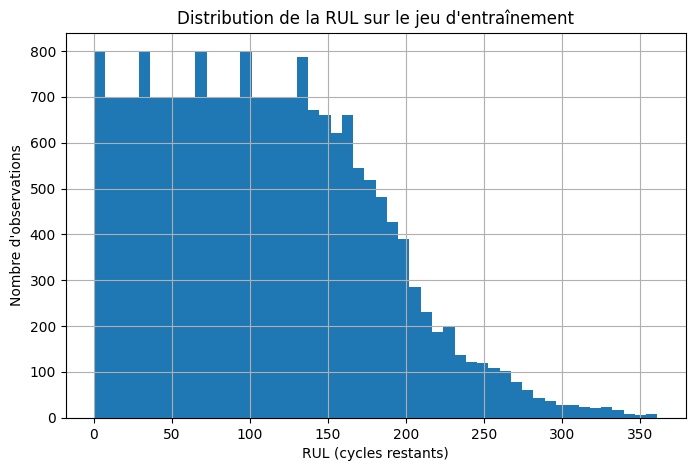


Aperçu pm_truth brut :


,id,cycle
0,1,112
1,2,98
2,3,69
3,4,82
4,5,91



Aperçu pm_test avec RUL :


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,max_cycle_test,RUL_end,RUL
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,31,112,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,31,112,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,31,112,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,31,112,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,31,112,138



Statistiques RUL (test) :


count    13096.000000
mean       141.238470
std         58.980114
min          7.000000
25%        102.000000
50%        140.000000
75%        179.000000
max        340.000000
Name: RUL, dtype: float64


Min RUL train / test : 0 7
Max RUL train / test : 361 340

Capteurs : ['setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
Settings : ['setting1', 'setting2', 'setting3']
Tri des données par id et cycle...
 Tri terminé

 Application du feature engineering SANS leakage...
 Feature engineering terminé

 Capteurs retenus pour les ratios : ['s9', 's14', 's4', 's3', 's17']

Répartition de la cible label_maintenance (train) :
label_maintenance
0    0.849741
1    0.150259
Name: proportion, dtype: float64

Proportion de lignes train avec RUL ≤ 30 cycles : 15.0%

 Calcul de la matrice de corrélation...

 Nettoyage des NaN...
  TRAIN : 6500 NaN avant → 0 après
  TEST  : 6500 NaN avant → 0 après


In [23]:
# 4. Construction de la RUL & feature engineering avancée
#  RUL pour le TRAIN 
max_cycle_train = pm_train.groupby("id")["cycle"].transform("max")
pm_train["RUL"] = max_cycle_train - pm_train["cycle"]

print("Aperçu pm_train avec RUL :")
display(pm_train.head())
print("\nStatistiques RUL (train) :")
display(pm_train["RUL"].describe())

# Visualisation de la distribution de la RUL sur le train
plt.figure()
pm_train["RUL"].hist(bins=50)
plt.xlabel("RUL (cycles restants)")
plt.ylabel("Nombre d'observations")
plt.title("Distribution de la RUL sur le jeu d'entraînement")
plt.show()



# RUL pour le TEST

print("\nAperçu pm_truth brut :")
display(pm_truth.head())

# pm_truth : colonnes ['id', 'cycle'] où 'cycle' = RUL au dernier cycle (RUL_end)
pm_truth_rul = pm_truth.rename(columns={"cycle": "RUL_end"})

# Dernier cycle observé pour chaque moteur dans pm_test
max_cycle_test = (
    pm_test.groupby("id")["cycle"]
    .max()
    .reset_index()
    .rename(columns={"cycle": "max_cycle_test"})
)

# Fusion avec RUL_end
pm_test = pm_test.merge(max_cycle_test, on="id", how="left")
pm_test = pm_test.merge(pm_truth_rul, on="id", how="left")

# RUL pour chaque ligne de pm_test
pm_test["RUL"] = (pm_test["max_cycle_test"] - pm_test["cycle"]) + pm_test["RUL_end"]

print("\nAperçu pm_test avec RUL :")
display(pm_test.head())
print("\nStatistiques RUL (test) :")
display(pm_test["RUL"].describe())

print("\nMin RUL train / test :", pm_train["RUL"].min(), pm_test["RUL"].min())
print("Max RUL train / test :", pm_train["RUL"].max(), pm_test["RUL"].max())


#  Définition des colonnes de base

id_col = "id"
cycle_col = "cycle"

all_cols = pm_train.columns.tolist()
sensor_cols = [c for c in all_cols if c.startswith("s")]
setting_cols = [c for c in all_cols if c.startswith("setting")]

print("\nCapteurs :", sensor_cols)
print("Settings :", setting_cols)

print("Tri des données par id et cycle...")
pm_train = pm_train.sort_values(['id', 'cycle']).reset_index(drop=True)
pm_test = pm_test.sort_values(['id', 'cycle']).reset_index(drop=True)
print(" Tri terminé")


def add_time_series_features(df):
    
    # # (1) Features basiques sur le cycle actuel
    #
    df["log_cycle"] = np.log1p(df[cycle_col])
    df["sqrt_cycle"] = np.sqrt(df[cycle_col])
    df["cycle_squared"] = df[cycle_col] ** 2
    
    
    # # (2) LAG features (valeurs passées)
    #
    for lag in [1, 3, 5]:  # Décalages de 1, 3, 5 cycles
        for col in sensor_cols[:5]:  # Top 5 capteurs
            df[f"{col}_lag_{lag}"] = df.groupby(id_col)[col].shift(lag)
    
    
    # # (3) Deltas par rapport au PREMIER cycle (état neuf)
    #
    first_vals = df.groupby(id_col)[sensor_cols].transform("first")
    for col in sensor_cols:
        df[f"{col}_delta_first"] = df[col] - first_vals[col]
    
    
    # # (4) ROLLING MEAN (fenêtre fixe passée uniquement)
    #
    window_ma = 5
    for col in sensor_cols:
        df[f"{col}_rolling_mean_{window_ma}"] = (
            df.groupby(id_col)[col]
              .rolling(window=window_ma, min_periods=1)
              .mean()
              .reset_index(level=0, drop=True)
        )
    
    
    # # (5) ROLLING STD (volatilité passée)
    #
    window_std = 10
    for col in sensor_cols[:5]:  # Top 5 pour limiter les features
        df[f"{col}_rolling_std_{window_std}"] = (
            df.groupby(id_col)[col]
              .rolling(window=window_std, min_periods=3)
              .std()
              .reset_index(level=0, drop=True)
        )
    
    
    # # (6) TENDANCE (pente) sur fenêtre glissante
    #
    window_trend = 10
    for col in sensor_cols[:5]:
        roll = df.groupby(id_col)[col].rolling(window=window_trend, min_periods=3)
        df[f"{col}_trend_{window_trend}"] = (
            roll.apply(
                lambda x: (x.iloc[-1] - x.iloc[0]) / (len(x) - 1) if len(x) > 1 else 0,
                raw=False,
            ).reset_index(level=0, drop=True)
        )
    
    
    # # (7) CUMUL (min/max historique jusqu'à maintenant)
    #
    for col in sensor_cols[:5]:
        df[f"{col}_cummax"] = df.groupby(id_col)[col].cummax()
        df[f"{col}_cummin"] = df.groupby(id_col)[col].cummin()
    
    return df


# # Appliquer le feature engineering corrigé
#
print("\n Application du feature engineering SANS leakage...")
pm_train = add_time_series_features(pm_train)
pm_test = add_time_series_features(pm_test)
print(" Feature engineering terminé")


# Sélection des capteurs à forte variance
sensor_variances = pm_train[sensor_cols].var().sort_values(ascending=False)
top_sensor_cols = sensor_variances.index[:5].tolist()
print(f"\n Capteurs retenus pour les ratios : {top_sensor_cols}")


def add_ratio_features(df, cols):
    #Crée des ratios entre capteurs (interactions physiques)
    
    # Utiliser pd.concat pour éviter la fragmentation
    new_features = {}
    
    for i in range(len(cols)):
        for j in range(i + 1, len(cols)):
            c1, c2 = cols[i], cols[j]
            new_name = f"{c1}_over_{c2}"
            new_features[new_name] = df[c1] / df[c2].replace(0, np.nan)
    
    # Ajouter toutes les colonnes en une fois
    df = pd.concat([df, pd.DataFrame(new_features, index=df.index)], axis=1)
    
    return df


pm_train = add_ratio_features(pm_train, top_sensor_cols)
pm_test = add_ratio_features(pm_test, top_sensor_cols)


# # Sélection des features + réduction de corrélation
#
# Cible de classification : décision de maintenance dans une fenêtre métier
MAINTENANCE_WINDOW = 30  # hypothèse métier (en cycles)

pm_train["label_maintenance"] = (pm_train["RUL"] <= MAINTENANCE_WINDOW).astype(int)
pm_test["label_maintenance"]  = (pm_test["RUL"] <= MAINTENANCE_WINDOW).astype(int)

TARGET_COL = "label_maintenance"

print("\nRépartition de la cible label_maintenance (train) :")
print(pm_train["label_maintenance"].value_counts(normalize=True).rename("proportion"))

prop_below = (pm_train["RUL"] <= MAINTENANCE_WINDOW).mean()
print(f"\nProportion de lignes train avec RUL ≤ {MAINTENANCE_WINDOW} cycles : {prop_below:.1%}")


# Colonnes à exclure des features (identifiants + cibles)
# Colonnes à exclure des features (identifiants + cibles)
cols_to_exclude = {
    id_col,
    cycle_col,
    "RUL",
    "label_maintenance",
    "RUL_end",
    "max_cycle_test",  # Ajouté
}

# Sélection des features candidates
candidate_features = [c for c in pm_train.columns if c not in cols_to_exclude]

# Garde uniquement les colonnes numériques
pm_train_num = pm_train[candidate_features].select_dtypes(include=[np.number])
numeric_features = pm_train_num.columns.tolist()

# Matrice de corrélation (sur TRAIN uniquement)
print("\n Calcul de la matrice de corrélation...")
corr = pm_train_num.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Suppression des features hautement corrélées (> 0.98)
high_corr_cols = [col for col in upper.columns if any(upper[col] > 0.98)]

FEATURE_COLS = [c for c in numeric_features if c not in high_corr_cols]

#  Nettoyage des NaN 

def clean_nan_values(df, feature_cols):
    
    
    n_nan_before = df[feature_cols].isna().sum().sum()
    
    # Forward fill par moteur (pour les rolling windows)
    df[feature_cols] = df.groupby(id_col)[feature_cols].ffill()
    
    # Remplir les NaN restants par 0
    df[feature_cols] = df[feature_cols].fillna(0.0)
    
    n_nan_after = df[feature_cols].isna().sum().sum()
    
    return df, n_nan_before, n_nan_after


print("\n Nettoyage des NaN...")

pm_train, nan_before_train, nan_after_train = clean_nan_values(pm_train, FEATURE_COLS)
print(f"  TRAIN : {nan_before_train} NaN avant → {nan_after_train} après")

pm_test, nan_before_test, nan_after_test = clean_nan_values(pm_test, FEATURE_COLS)
print(f"  TEST  : {nan_before_test} NaN avant → {nan_after_test} après")



## 5. Séparation des données en train / validation / test

Une fois les features (`FEATURE_COLS`) et la cible binaire `label_failure` prêtes, on sépare les données en plusieurs jeux :

- `X_train_full`, `y_train_full` : tout l’historique d’entraînement ;
- `X_train`, `X_val`, `y_train`, `y_val` : découpe interne pour choisir / régler les modèles ;
- `X_test`, `y_test` : jeu de test final, utilisé uniquement pour l’évaluation finale.

La séparation est faite **par moteur** (`id`) afin d’éviter :

- qu’un même moteur apparaisse en même temps dans le train et dans la validation ;
- des fuites temporelles (les derniers cycles d’un moteur en validation “voient” indirectement les premiers cycles du même moteur en train).

On est maintenant en situation standard de **classification supervisée** :  
`X_*` contient les features dérivées des capteurs, `y_*` indique si le moteur est à risque de panne à horizon `HORIZON`.


In [24]:
# 5. Séparation des données (train / val / test)

# 5.1. Construction de X et y
X_train_full = pm_train[FEATURE_COLS].copy()
y_train_full = pm_train[TARGET_COL].copy()

X_test = pm_test[FEATURE_COLS].copy()
y_test = pm_test[TARGET_COL].copy()

print("Taille X_train_full :", X_train_full.shape)
print("Taille y_train_full :", y_train_full.shape)
print("Taille X_test       :", X_test.shape)
print("Taille y_test       :", y_test.shape)


# 5.2. Split PAR MOTEUR (évite le leakage temporel)
print("\nSéparation train/val par moteur...")

unique_ids = pm_train['id'].unique()
train_ids, val_ids = train_test_split(
    unique_ids,
    test_size=0.2,
    random_state=RANDOM_STATE
)

train_mask = pm_train['id'].isin(train_ids)
val_mask = pm_train['id'].isin(val_ids)

X_train = pm_train.loc[train_mask, FEATURE_COLS].copy()
y_train = pm_train.loc[train_mask, TARGET_COL].copy()

X_val = pm_train.loc[val_mask, FEATURE_COLS].copy()
y_val = pm_train.loc[val_mask, TARGET_COL].copy()

# Vérification anti-fuite
assert len(set(train_ids) & set(val_ids)) == 0, " Moteurs en commun détectés !"


Taille X_train_full : (20631, 115)
Taille y_train_full : (20631,)
Taille X_test       : (13096, 115)
Taille y_test       : (13096,)

Séparation train/val par moteur...


## 6. Modèles de base (classification) et métriques

Avant de passer à des modèles plus puissants, on commence par des **baselines simples** pour se donner des points de comparaison :

- un **DummyClassifier** qui prédit toujours la classe majoritaire ;
- une **régression logistique** (`LogisticRegression`) avec pondération des classes.

On utilise une même fonction `evaluate_classifier` qui :

- entraîne le modèle sur le train ;
- évalue sur le jeu de validation ;
- calcule les principales métriques de **classification binaire** :

  - `accuracy`,
  - `F1-score`,
  - `ROC-AUC`,
  - rapport de classification,
  - matrice de confusion.

Ces baselines servent de référence : les modèles plus avancés (RandomForest, XGBoost) devront faire **significativement mieux** pour être intéressants.


In [25]:
#  Modèles de base (DummyClassifier, LogisticRegression)

def evaluate_classifier(model, X_tr, y_tr, X_va, y_va, name=""):
    """
    Entraîne un modèle de classification binaire et affiche les principales métriques.
    """
    model.fit(X_tr, y_tr)
    
    y_pred = model.predict(X_va)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_va)[:, 1]
    else:
        y_proba = None
    
    acc = accuracy_score(y_va, y_pred)
    
    f1 = f1_score(y_va, y_pred, zero_division=0)
    auc = roc_auc_score(y_va, y_proba) 
    
    print(f"\n=== {name} ===")
    print(f"Accuracy : {acc:.3f}")
    print(f"F1-score : {f1:.3f}")
    if y_proba is not None:
        print(f"ROC-AUC  : {auc:.3f}")
    
    print("\nClassification report :")
    print(classification_report(y_va, y_pred, zero_division=0))
    
    print("Matrice de confusion :")
    print(confusion_matrix(y_va, y_pred))
    
    return {
        "model": model,
        "acc": acc,
        "f1": f1,
        "auc": auc,
    }

# Baseline 1 : DummyClassifier (classe majoritaire) 
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)
res_dummy = evaluate_classifier(
    dummy_clf, X_train, y_train, X_val, y_val, name="DummyClassifier (most_frequent)"
)

# Baseline 2 : LogisticRegression 
# Utilisation d'un Pipeline pour normaliser les données avant la régression
log_reg = make_pipeline(
    StandardScaler(), 
    LogisticRegression(
        max_iter=1000, 
        class_weight="balanced",
        random_state=RANDOM_STATE
    )
)

res_logreg = evaluate_classifier(
    log_reg, X_train, y_train, X_val, y_val, name="LogisticRegression (Scaled)"
)


=== DummyClassifier (most_frequent) ===
Accuracy : 0.848
F1-score : 0.000
ROC-AUC  : 0.500

Classification report :
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      3450
           1       0.00      0.00      0.00       620

    accuracy                           0.85      4070
   macro avg       0.42      0.50      0.46      4070
weighted avg       0.72      0.85      0.78      4070

Matrice de confusion :
[[3450    0]
 [ 620    0]]

=== LogisticRegression (Scaled) ===
Accuracy : 0.969
F1-score : 0.905
ROC-AUC  : 0.996

Classification report :
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3450
           1       0.86      0.96      0.90       620

    accuracy                           0.97      4070
   macro avg       0.92      0.97      0.94      4070
weighted avg       0.97      0.97      0.97      4070

Matrice de confusion :
[[3350  100]
 [  25  595]]


## 7. Modèles non linéaires : RandomForest et XGBoost

On entraîne ensuite deux modèles plus puissants, adaptés aux données tabulaires :

- **RandomForestClassifier** (ensemble d’arbres de décision en bagging) ;
- **XGBClassifier** (gradient boosting XGBoost).

Objectifs :

- mieux gérer les relations non linéaires entre capteurs et probabilité de panne ;
- prendre en compte le **déséquilibre de classes** (`class_weight="balanced"`, `scale_pos_weight`, etc.) ;
- comparer leurs performances aux baselines sur le jeu de validation avec les mêmes métriques (accuracy, F1, ROC-AUC, etc.).

Les résultats servent à choisir un **modèle final** à entraîner sur tout le jeu de données d’entraînement.


In [26]:
#  Modèles non linéaires : RandomForest & XGBoost

from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,              # Limiter pour réduire overfitting
    min_samples_leaf=5,
    class_weight="balanced",   #  Important pour déséquilibre
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

res_rf = evaluate_classifier(
    rf_clf, X_train, y_train, X_val, y_val, name="RandomForestClassifier"
)


from xgboost import XGBClassifier

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_clf = XGBClassifier(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,  #  Gestion déséquilibre
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=RANDOM_STATE,
)

res_xgb = evaluate_classifier(
    xgb_clf, X_train, y_train, X_val, y_val, name="XGBClassifier"
)





=== RandomForestClassifier ===
Accuracy : 0.978
F1-score : 0.928
ROC-AUC  : 0.997

Classification report :
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3450
           1       0.91      0.95      0.93       620

    accuracy                           0.98      4070
   macro avg       0.95      0.96      0.96      4070
weighted avg       0.98      0.98      0.98      4070

Matrice de confusion :
[[3392   58]
 [  33  587]]

=== XGBClassifier ===
Accuracy : 0.985
F1-score : 0.948
ROC-AUC  : 0.998

Classification report :
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3450
           1       0.96      0.94      0.95       620

    accuracy                           0.98      4070
   macro avg       0.98      0.96      0.97      4070
weighted avg       0.98      0.98      0.98      4070

Matrice de confusion :
[[3427   23]
 [  40  580]]


## 8. Modèle final et évaluation sur le jeu de test

Le modèle retenu comme final est ici **XGBClassifier**, qui offre le meilleur compromis sur les métriques de validation.

Étapes :

1. ré-entraîner `XGBClassifier` sur **tout le jeu d’entraînement** (`X_train_full`, `y_train_full`) ;
2. évaluer une seule fois sur le **jeu de test** (`X_test`, `y_test`) ;
3. analyser les résultats :

   - `accuracy` sur le test,
   - `F1-score` (qualité globale de la détection des moteurs à risque),
   - `ROC-AUC` (capacité à discriminer les moteurs à risque des moteurs sains).

Ces scores sont ceux qui peuvent être reportés dans le **README** ou dans un CV / portfolio.


In [27]:
#  Modèle final : entraînement sur tout le train & évaluation sur TEST

best_model = xgb_clf  # choisi sur la validation

print(" Ré-entraîner le modèle final (XGBClassifier) sur tout le TRAIN...")
best_model.fit(X_train_full, y_train_full)

print("\n=== Évaluation finale sur le jeu de TEST ===\n")
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]

metrics_test = {
    "accuracy_test": accuracy_score(y_test, y_test_pred),
    "f1_test": f1_score(y_test, y_test_pred),
    "roc_auc_test": roc_auc_score(y_test, y_test_proba),
}

display(
    pd.DataFrame(metrics_test, index=["XGBClassifier"])
      .T.rename(columns={"XGBClassifier": "score"})
      .style.format("{:.3f}")
)

print("\n📊 Aperçu des prédictions (quelques moteurs) :")
preview_df = pd.DataFrame({
    "y_test": y_test.values,
    "y_pred": y_test_pred,
    "proba_positif": y_test_proba,
})
display(preview_df.head(10))


 Ré-entraîner le modèle final (XGBClassifier) sur tout le TRAIN...

=== Évaluation finale sur le jeu de TEST ===



,score
accuracy_test,0.992
f1_test,0.853
roc_auc_test,0.998



📊 Aperçu des prédictions (quelques moteurs) :


,y_test,y_pred,proba_positif
0,0,0,0.000004
1,0,0,0.000006
2,0,0,0.000004
3,0,0,0.000004
4,0,0,0.000004
5,0,0,0.000003
6,0,0,0.000004
7,0,0,0.000003
8,0,0,0.000004
9,0,0,0.000002


##  Interprétabilité du modèle : importance des variables & SHAP

Dans cette section, on cherche à comprendre **pourquoi** le modèle prédit qu'un moteur
est "à risque" (classe 1) ou "non à risque" (classe 0).

On utilise deux approches complémentaires :

- **Importances de variables du modèle XGBoost** : donnent une vue globale des
  variables les plus utilisées par le modèle.
- **SHAP (SHapley Additive exPlanations)** :
  - importance globale (quelles features comptent le plus en moyenne) ;
  - explications locales (pourquoi un moteur précis est prédit comme à risque).


 Top variables importantes selon XGBClassifier


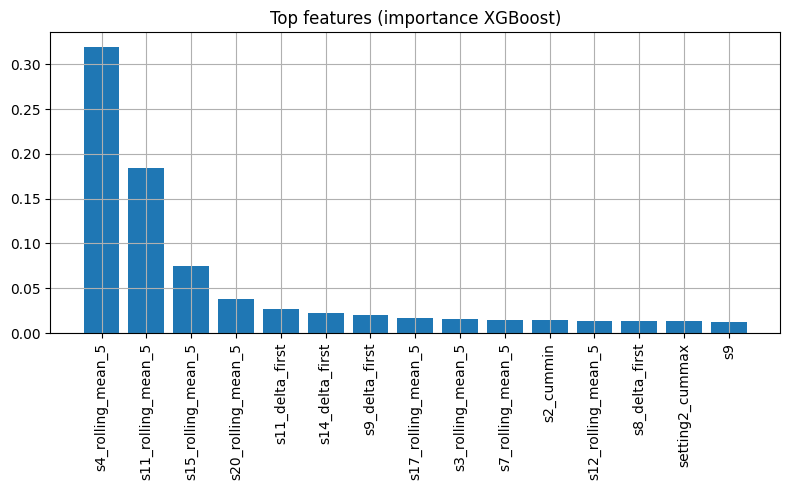

,feature,importance
0,s4_rolling_mean_5,0.319625
1,s11_rolling_mean_5,0.183692
2,s15_rolling_mean_5,0.075256
3,s20_rolling_mean_5,0.037484
4,s11_delta_first,0.027252
5,s14_delta_first,0.022873
6,s9_delta_first,0.020564
7,s17_rolling_mean_5,0.016824
8,s3_rolling_mean_5,0.015463
9,s7_rolling_mean_5,0.014876


In [28]:
#  Importances de variables (XGBClassifier)

import numpy as np
import matplotlib.pyplot as plt

print(" Top variables importantes selon XGBClassifier")

# Noms de colonnes
if hasattr(X_train_full, "columns"):
    feature_names = X_train_full.columns
else:
    feature_names = [f"f{i}" for i in range(X_train_full.shape[1])]

importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]  # tri décroissant

n_top = 15  # nombre de variables à afficher

plt.figure()
plt.title("Top features (importance XGBoost)")
plt.bar(
    range(n_top),
    importances[indices[:n_top]],
)
plt.xticks(
    range(n_top),
    [feature_names[i] for i in indices[:n_top]],
    rotation=90
)
plt.tight_layout()
plt.show()

feat_imp_df = (
    pd.DataFrame(
        {
            "feature": [feature_names[i] for i in indices],
            "importance": importances[indices],
        }
    )
    .head(30)
)

display(feat_imp_df)


 Calcul des valeurs SHAP (ça peut prendre un peu de temps)...
 Beeswarm plot : impact des variables sur la classe 'moteur à risque'


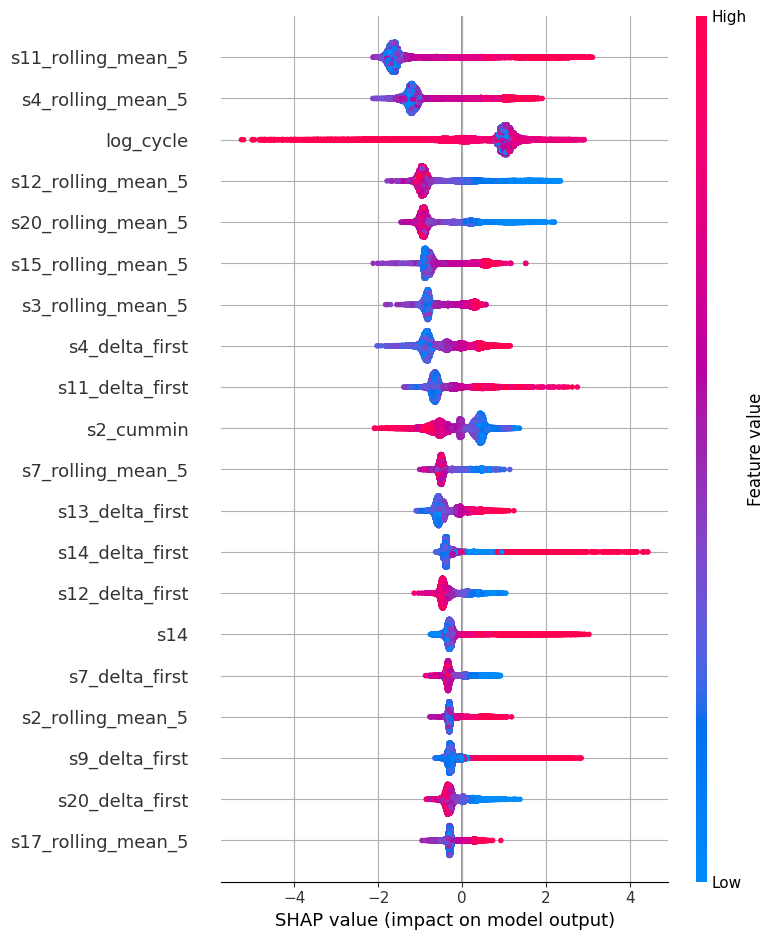

 Bar plot : importance globale moyenne des variables


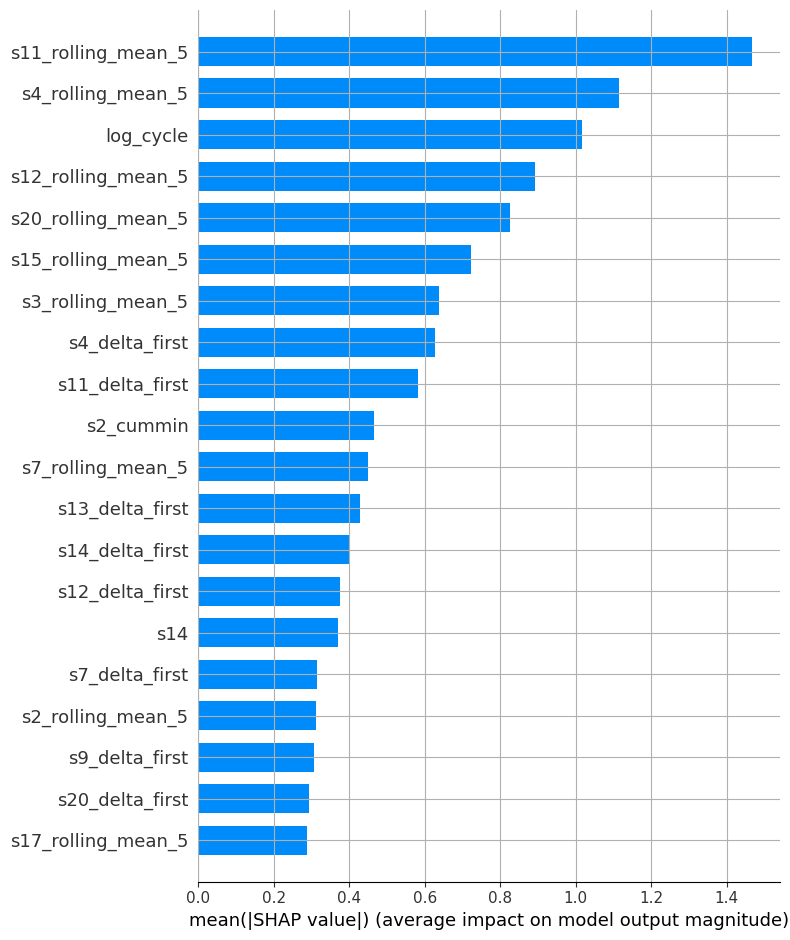

In [29]:
#  SHAP : vue globale de l'impact des features

import shap

print(" Calcul des valeurs SHAP (ça peut prendre un peu de temps)...")

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train_full)

# Pour un modèle binaire, shap_values peut être une liste [classe0, classe1]
if isinstance(shap_values, list):
    shap_values_class1 = shap_values[1]
else:
    shap_values_class1 = shap_values

print(" Beeswarm plot : impact des variables sur la classe 'moteur à risque'")
shap.summary_plot(shap_values_class1, X_train_full)

print(" Bar plot : importance globale moyenne des variables")
shap.summary_plot(shap_values_class1, X_train_full, plot_type="bar")
